  A) Packages

In [41]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

B) Helper methods

In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def der_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def der_tanh(x):
    return 1 - np.tanh(x) ** 2

def add_titles_labels(fig, ax1, ax2, learning_rate, legend, legend_fontsize=16):
    fig.suptitle(f"Learning rate = {learning_rate}", fontsize=20)
    ax1.set_title('Training error energy', fontsize=22)
    ax2.set_title('Training gradient', fontsize=22)
    ax1.legend(legend, fontsize=legend_fontsize);             ax2.legend(legend, fontsize=legend_fontsize)
    ax1.set_xlabel('Epoch');        ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Error');        ax2.set_ylabel('Delta')
    plt.show()

C) Class Layer

In [43]:
class Layer:
    def __init__(self, n_inputs, n_neurons, activation="sigmoid"):
        self.W = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.activation = activation

    def forward(self, input):
        self.input = input
        self.field = np.dot(input, self.W)

        if self.activation == "sigmoid":
            self.output = sigmoid(self.field)
        elif self.activation == "tanh":
            self.output = tanh(self.field)

        return self.output

    def backward(self, gradient, learning_rate):
        if self.activation == "sigmoid":
            self.delta = np.multiply(gradient, der_sigmoid(self.field))
        elif self.activation == "tanh":
            self.delta = np.multiply(gradient, der_tanh(self.field))

        self.dW = np.dot(self.input.T, self.delta)
        self.W += learning_rate * self.dW
        
        return np.dot(self.delta, self.W.T)

D) Class MultiLayerPerceptron

In [44]:
class MultiLayerPerceptron:
    def __init__(self, layers, learning_rate=0.2, max_epochs=50, tolerance=1e-2):
        self.layers = layers
        self.dimensions = [layer.W.shape[1] for layer in layers]
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.errors, self.deltas = [], []

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, delta, learning_rate):
        for layer in reversed(self.layers):
            delta = layer.backward(delta, learning_rate)

    def train(self, X, y):
        for epoch in range(self.max_epochs):
            # Forward and backward pass
            output = self.forward(X)
            error = y - output
            self.backward(error, self.learning_rate)

            # Stop training if error is below tolerance
            squared_error = np.mean(np.square(error))
            if(squared_error < self.tolerance):
                print(f"MLP with dimensions {self.dimensions} stopped training at epoch : {epoch}")
                break
            
            # Save error and delta for plotting
            self.errors.append(squared_error)
            self.deltas.append(np.mean(np.abs(self.layers[-1].delta)))

E) Load New York Stock Exchange Dataset https://www.kaggle.com/datasets/dgawlik/nyse

In [45]:
# load data.csv to a pandas dataframe
df = pd.read_csv('NYStockExchange.csv')

# exclude columns of type object and remove index column
df = df.select_dtypes(exclude=['object'])
df = df.drop(['Unnamed: 0'], axis=1)

# remove rows with NaN values
df = df.dropna()

# normalize each column using min-max normalization
for col in df.columns:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
# validate min-max normalization
for mn, mx in zip(df.min(), df.max()):
    assert mn == 0 and mx == 1

# random shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

# select column to predict
atr_predict = "Total Revenue"
# create numpy array y from column 'atr_predict'
y = np.array([[value] for value in df[atr_predict]])

# create numpy array X from all columns except 'atr_predict'
X = np.array(df.drop([atr_predict], axis=1))

print(X.shape, y.shape)

(1299, 75) (1299, 1)


F) Define Hyperparameters

In [46]:
learning_rates = [0.0005, 0.001, 0.002]
tolerance = 1e-2
max_epochs = 50
input_size = 75
min_neurons, max_neurons = 1, 5

G) MLP: 1 hidden layer

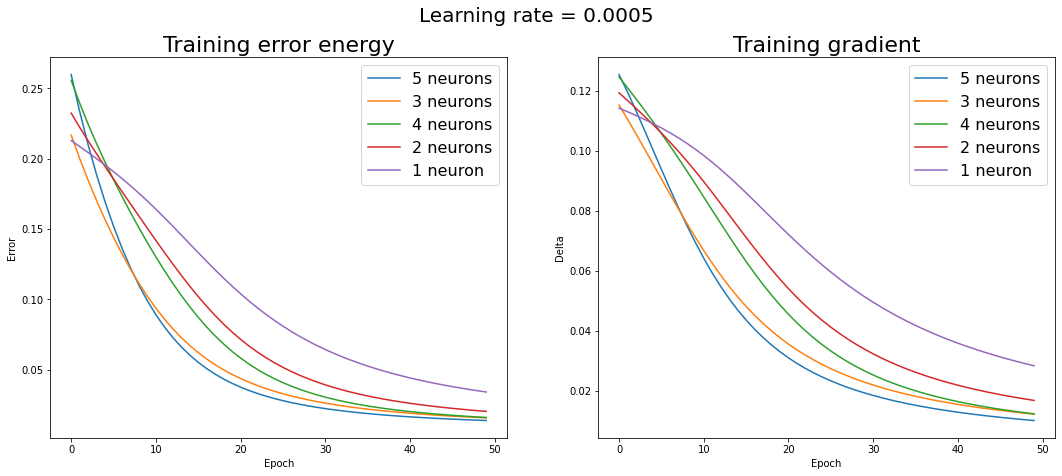

MLP with dimensions [3, 1] stopped training at epoch : 49
MLP with dimensions [4, 1] stopped training at epoch : 48
MLP with dimensions [5, 1] stopped training at epoch : 38


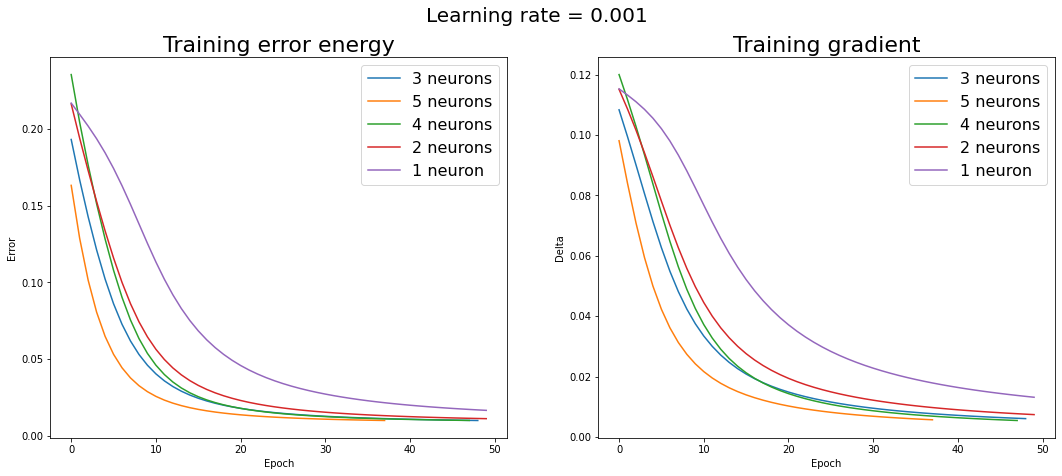

MLP with dimensions [2, 1] stopped training at epoch : 36
MLP with dimensions [3, 1] stopped training at epoch : 27
MLP with dimensions [4, 1] stopped training at epoch : 22
MLP with dimensions [5, 1] stopped training at epoch : 20


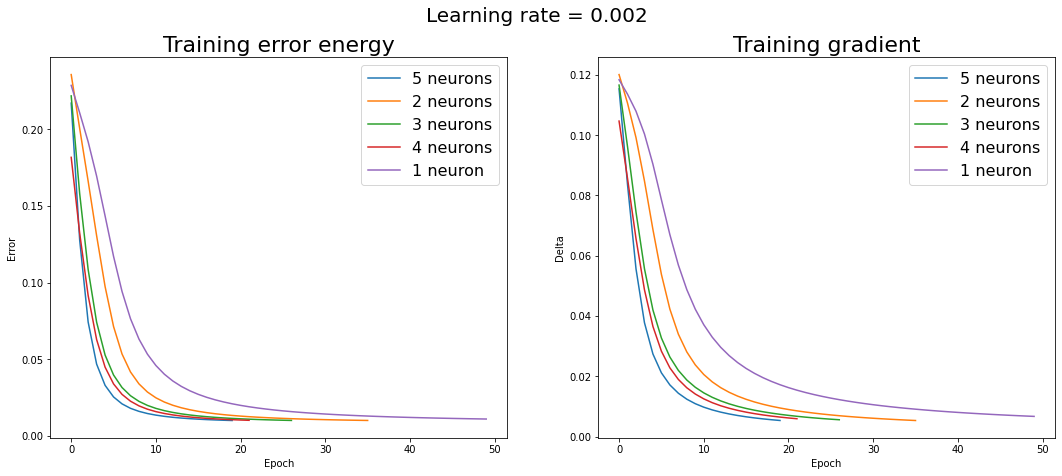

In [47]:
for learning_rate in learning_rates:
    # create two plots for training error and delta
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    rank = []
    for neurons in range (min_neurons, max_neurons + 1):
        mlp = MultiLayerPerceptron(
            layers=[Layer(input_size, neurons), Layer(neurons, 1)], 
            learning_rate=learning_rate, max_epochs=max_epochs, tolerance=tolerance
        )
        mlp.train(X, y)
        rank.append([mlp.errors[-1], neurons, mlp.errors, mlp.deltas])

    # sort by error and plot results in such order
    rank.sort()
    legend = []
    for mlp_results in rank:
        [neurons, errors, deltas]  = mlp_results[1:4]
        legend.append(f"{neurons} neuron{'' if neurons == 1 else 's'}")
        ax1.plot(errors)
        ax2.plot(deltas)

    add_titles_labels(fig, ax1, ax2, learning_rate, legend)

H) MLP: 2 hidden layers

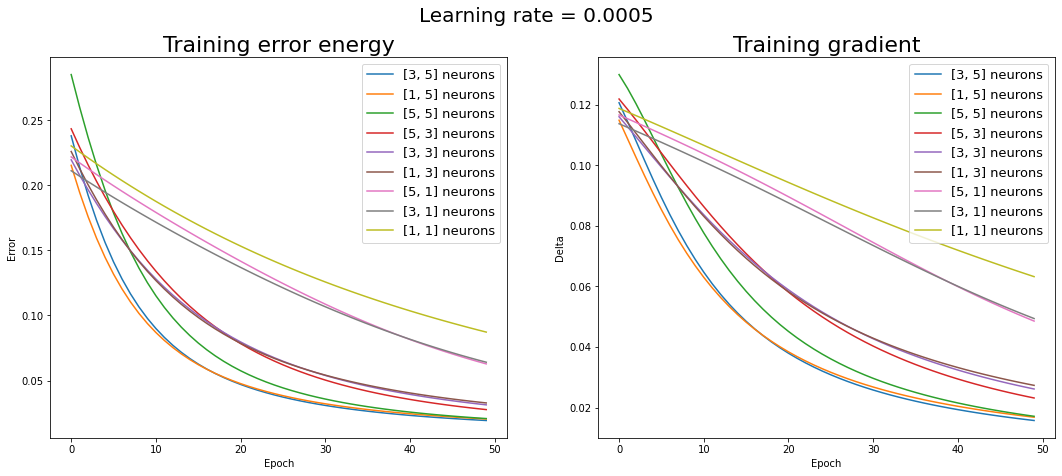

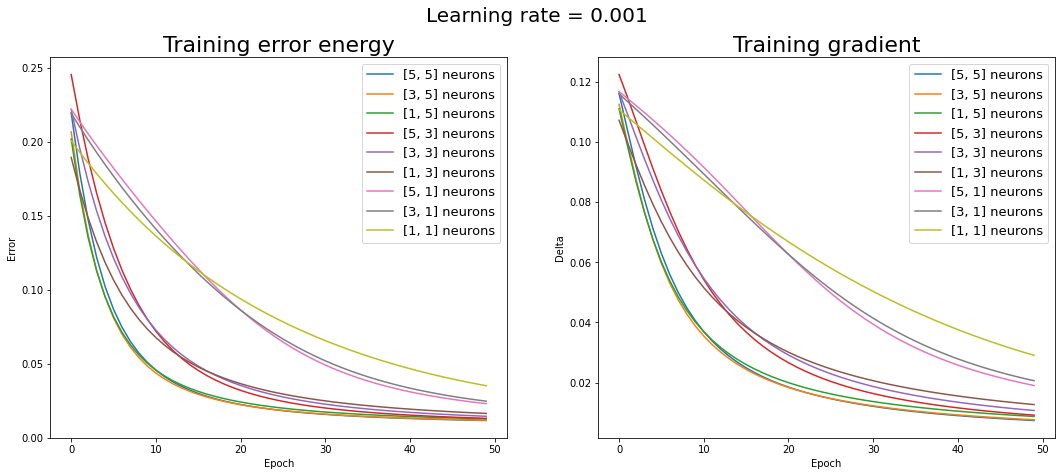

MLP with dimensions [1, 5, 1] stopped training at epoch : 47
MLP with dimensions [3, 5, 1] stopped training at epoch : 38
MLP with dimensions [5, 3, 1] stopped training at epoch : 43
MLP with dimensions [5, 5, 1] stopped training at epoch : 37


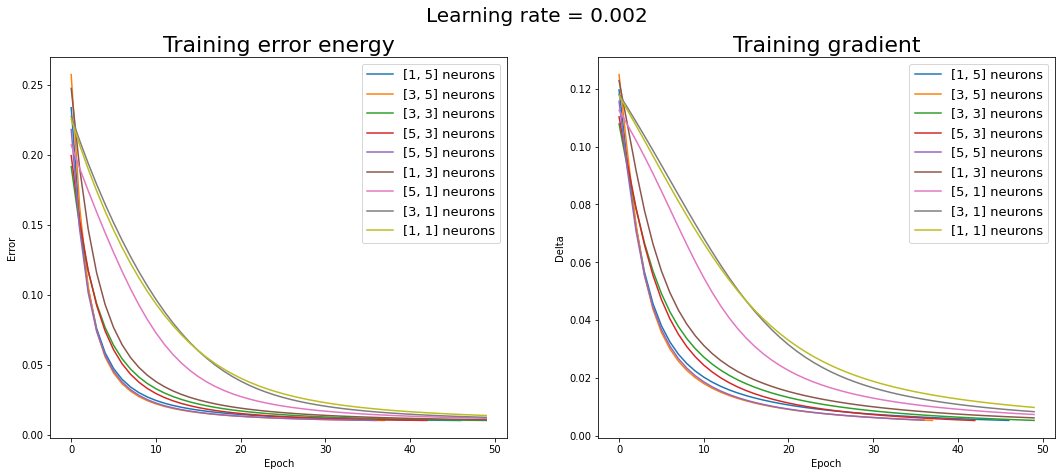

In [48]:
for learning_rate in learning_rates:
    # Create two plots for training error and delta
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Create and train MLPs with different architectures
    
    rank = []
    for n1 in range (min_neurons, max_neurons + 1, 2):
        for n2 in range (min_neurons, max_neurons + 1, 2):
            mlp = MultiLayerPerceptron(
                layers=[Layer(input_size, n1), Layer(n1, n2), Layer(n2, 1)], 
                learning_rate=learning_rate, max_epochs=max_epochs, tolerance=tolerance
            )
            mlp.train(X, y)
            rank.append([mlp.errors[-1], n1, n2, mlp.errors, mlp.deltas])

    # Sort MLPs by error and plot results in such order
    rank.sort()
    legend = []
    for mlp_results in rank:
        [n1, n2, errors, deltas] = mlp_results[1:5]
        legend.append(f"[{n1}, {n2}] neurons")
        ax1.plot(errors)
        ax2.plot(deltas)

    add_titles_labels(fig, ax1, ax2, learning_rate, legend, legend_fontsize=13)

I) MLP: 3 hidden layers

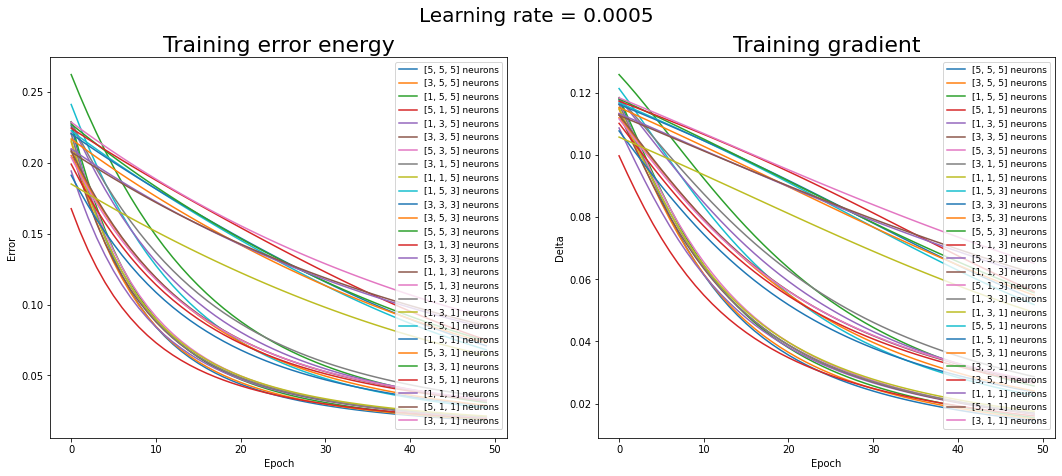

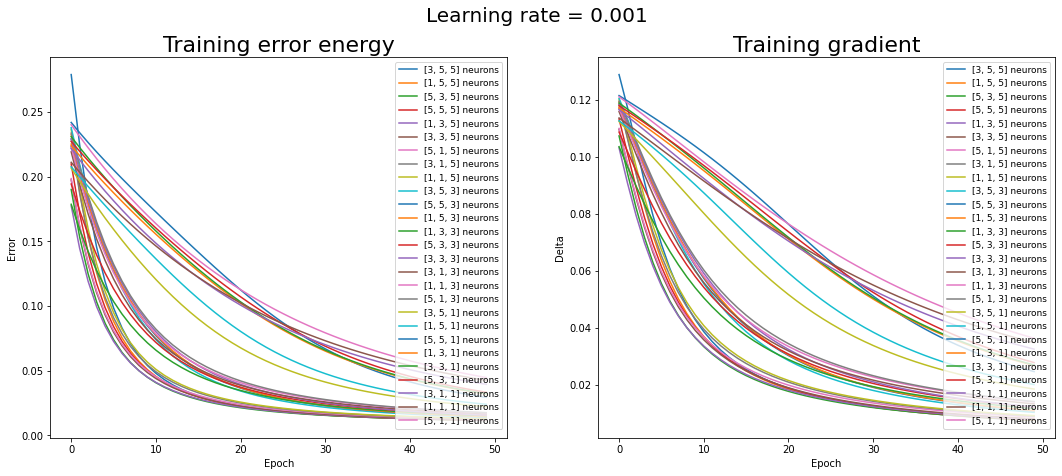

MLP with dimensions [1, 1, 5, 1] stopped training at epoch : 45
MLP with dimensions [1, 3, 5, 1] stopped training at epoch : 39
MLP with dimensions [1, 5, 3, 1] stopped training at epoch : 49
MLP with dimensions [1, 5, 5, 1] stopped training at epoch : 36
MLP with dimensions [3, 1, 5, 1] stopped training at epoch : 45
MLP with dimensions [3, 3, 5, 1] stopped training at epoch : 38
MLP with dimensions [3, 5, 3, 1] stopped training at epoch : 48
MLP with dimensions [3, 5, 5, 1] stopped training at epoch : 37
MLP with dimensions [5, 1, 5, 1] stopped training at epoch : 45
MLP with dimensions [5, 3, 5, 1] stopped training at epoch : 39
MLP with dimensions [5, 5, 3, 1] stopped training at epoch : 47
MLP with dimensions [5, 5, 5, 1] stopped training at epoch : 37


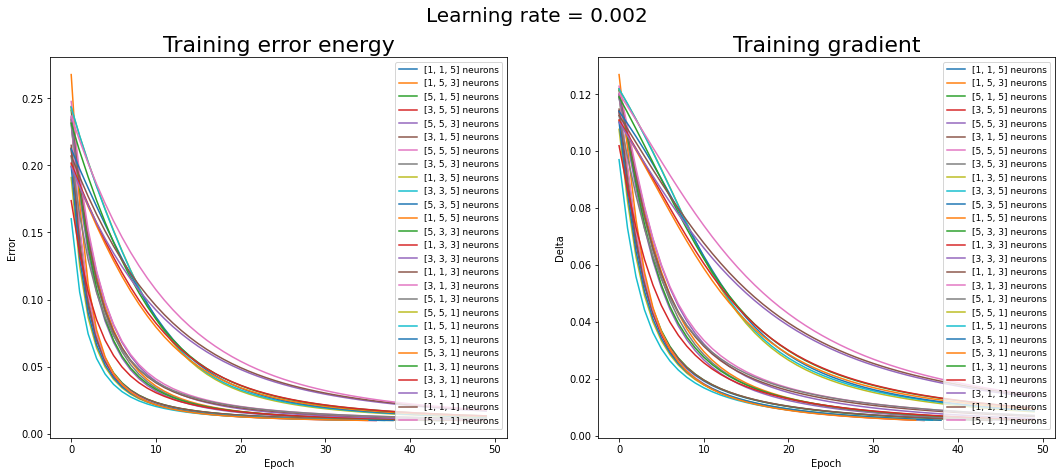

In [49]:
for learning_rate in learning_rates:
    # create two plots for training error and delta
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Create and train MLPs with different architectures
    rank = []
    for n1 in range (min_neurons, max_neurons + 1, 2):
        for n2 in range (min_neurons, max_neurons + 1, 2):
            for n3 in range (min_neurons, max_neurons + 1, 2):
                mlp = MultiLayerPerceptron(
                    layers=[Layer(input_size, n1), Layer(n1, n2), Layer(n2, n3), Layer(n3, 1)], 
                    learning_rate=learning_rate, max_epochs=max_epochs, tolerance=tolerance
                )
                mlp.train(X, y)
                rank.append([mlp.errors[-1], n1, n2, n3, mlp.errors, mlp.deltas])

    # Sort MLPs by error and plot results in such order
    rank.sort()
    legend = []
    for mlp_results in rank:
        [n1, n2, n3, errors, deltas] = mlp_results[1:6]
        legend.append(f"[{n1}, {n2}, {n3}] neurons")
        ax1.plot(errors)
        ax2.plot(deltas)

    add_titles_labels(fig, ax1, ax2, learning_rate, legend, legend_fontsize=9)